# Speech Signal Processing for Prosody - Semantics/Pragmatics Mapping

(C) 2018 by Damir Cavar, ...

## Introduction

...

## Librosa for Feature Extraction

In [43]:
import librosa, glob
import matplotlib.pyplot as plt
import librosa.display

### Root-Mean-Square (RMS) Energy for Each Frame

For all wav-files in the folder, load them and compute the RMSE vectors:

Analyzing: A_man_bought_a_car_in_Paris-DC-2.wav
Sampling rate: 22050
Data: [-0.01947346 -0.03268886 -0.02724907 ...  0.20243706  0.19471705
  0.20985296]


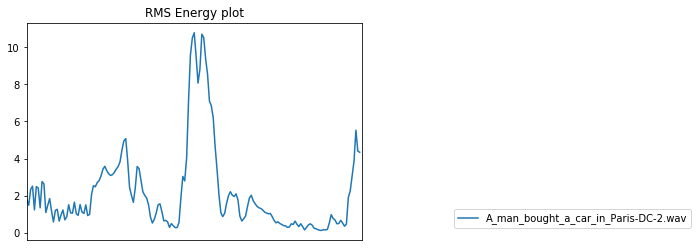

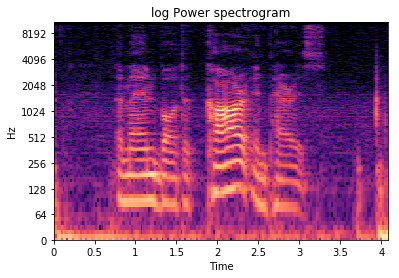

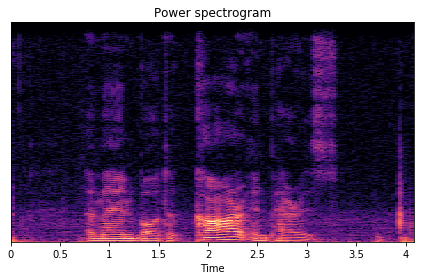

In [53]:
# plt.figure()
# plt.subplot(2, 1, 1)


# file_list = ( "A_man_bought_a_car_in_Paris-DC-1.wav",
#              "A_man_bought_a_car_in_Paris-DC-2.wav",
#             "A_man_bought_a_car_in_Paris-DC-3.wav",
#              "A_man_bought_a_car_in_Paris-DC-4.wav",
#             "A_man_bought_a_car_in_Paris-DC-5.wav")

file_list = ("A_man_bought_a_car_in_Paris-DC-2.wav", )

for wav in file_list: # glob.glob("*.wav"):
    print("Analyzing:", wav)
    y, sr = librosa.load(wav)
    librosa.feature.rmse(y=y)
    print("Sampling rate:", sr)
    print("Data:", y)
    S, phase = librosa.magphase(librosa.stft(y))
    rms = librosa.feature.rmse(S=S)
#     plt.semilogy(rms.T, label=wav) # 'RMS Energy')
    plt.plot(rms.T, label=wav)
    plt.xticks([])
    plt.xlim([0, rms.shape[-1]])
    plt.legend(loc = 'right', bbox_to_anchor=(2, 0.1))
    plt.title("RMS Energy plot")
    # plt.subplot(2, 1, 2)
    plt.figure()
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
    plt.title('log Power spectrogram')
    
    plt.figure()
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), x_axis='time')
    plt.title('Power spectrogram')
    
    plt.tight_layout()

Plot the scores over time:

### Trying Differentiation and stuff

(1, 176)


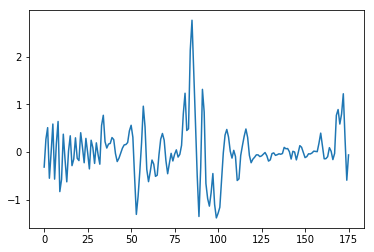

In [4]:
import numpy as np
# np.array([1,2,3]).shape
print(rms.shape)
# array = rms.flatten()
diffs = np.gradient(rms, axis = 1)
plt.plot(diffs.T )    

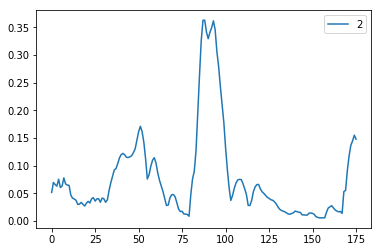

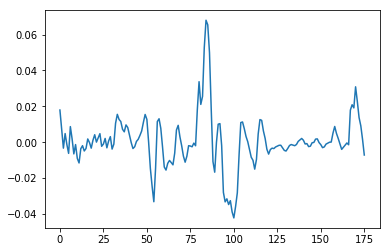

In [19]:
def plot_rms_energy(rosa_wav, label):
    rms = librosa.feature.rmse(y=y)
    plt.plot(rms.T, label=label)
    plt.legend()
    return rms

def plot_gradient(array, axis = 1):
    grad = np.gradient(rms, axis = axis)
    plt.plot(grad.T ) 
    return grad

plt.figure()
rms = plot_rms_energy(y, "2")

plt.figure()
grads =plot_gradient(rms)

In [38]:
grads = grads.flatten()
grad_min = np.min(grads) 
grad_max = np.max(grads)
grad_mean = np.mean(grads)

In [41]:
pos = np.where((grads- grad_mean) > 1.5*(grad_mean - grad_min))[0]
print(pos)
print(grads[pos])

[84 85]
[0.06799898 0.06544454]


## Use Google Speech API for Speech recognition

We need the module [SpeechRecognition](https://pypi.org/project/SpeechRecognition/):

In [3]:
import speech_recognition as sr
from pprint import pprint

See for more details on how to use the SpeechRecognition module [here](https://github.com/Uberi/speech_recognition/blob/master/examples/audio_transcribe.py).

In [4]:
r = sr.Recognizer()
with sr.AudioFile("A_man_bought_a_car_in_Paris-DC-2.wav") as source:
    audio = r.record(source)  # read the entire audio file
pprint(r.recognize_google(audio, show_all=True))

{'alternative': [{'confidence': 0.95500749,
                  'transcript': 'a man bought a car in Paris'},
                 {'transcript': 'a man bought the car in Paris'},
                 {'transcript': 'a man bought car in Paris'},
                 {'transcript': 'a man bought a car in Perris'}],
 'final': True}


We need to get the timing information, that is the Word Timestamps for the transcription that the ASR returns.

### Use Google Cloud Services directly
#### pricing: free upto 60 minutes of audio processed per month

In [8]:
import io
from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types

In [12]:
def transcribe_gcs_with_word_time_offsets(file_name):
    """Transcribe the given audio file asynchronously and output the word time
    offsets."""
    
    client = speech.SpeechClient()
    
    with io.open(file_name, 'rb') as audio_file:
        content = audio_file.read()
        audio = types.RecognitionAudio(content=content)
#     audio = types.RecognitionAudio(content=content)

    config = types.RecognitionConfig(
#         encoding=enums.RecognitionConfig.AudioEncoding.FLAC,
#         sample_rate_hertz=16000,
        language_code='en-US',
        enable_word_time_offsets=True)

    operation = client.long_running_recognize(config, audio)

    print('Waiting for operation to complete...')
    result = operation.result(timeout=90)

    for result in result.results:
        alternative = result.alternatives[0]
        print(u'Transcript: {}'.format(alternative.transcript))
        print('Confidence: {}'.format(alternative.confidence))

        for word_info in alternative.words:
            word = word_info.word
            start_time = word_info.start_time
            end_time = word_info.end_time
            print('Word: {}, start_time: {}, end_time: {}'.format(
                word,
                start_time.seconds + start_time.nanos * 1e-9,
                end_time.seconds + end_time.nanos * 1e-9))

transcribe_gcs_with_word_time_offsets(file_list[0])

Waiting for operation to complete...
Transcript: a man bought a car in Paris
Confidence: 0.9786056280136108
Word: a, start_time: 0.5, end_time: 0.8
Word: man, start_time: 0.8, end_time: 1.2
Word: bought, start_time: 1.2, end_time: 1.6
Word: a, start_time: 1.6, end_time: 1.7000000000000002
Word: car, start_time: 1.7000000000000002, end_time: 2.4
Word: in, start_time: 2.4, end_time: 2.6
Word: Paris, start_time: 2.6, end_time: 3.1
